<a href="https://colab.research.google.com/github/ShuichiroTsuda/TrendModel/blob/main/TrendModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytrends

In [2]:
import pandas as pd                        
from pytrends.request import TrendReq
import numpy as np
from scipy.optimize import minimize, basinhopping
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

pytrend = TrendReq(hl='ja-jp')

## データダウンロード


In [ ]:
keywords = ['倍返しだ']
pytrend.build_payload(kw_list=keywords, timeframe='2013-06-01 2014-06-30')
df = pd.DataFrame(pytrend.interest_over_time())

In [43]:
keywords = ['君の名は']
pytrend.build_payload(kw_list=keywords, timeframe='2016-08-12 2016-12-01')
df = pd.DataFrame(pytrend.interest_over_time())

In [44]:
df["rolling"] = df['君の名は'].rolling(12).mean()
df = df.dropna(subset=['rolling'])

In [45]:
df['rolling'] = df['rolling'] / np.max(df['rolling'])

In [46]:
df

,君の名は,isPartial,rolling
date,,,
2016-08-23,17,False,0.133413
2016-08-24,19,False,0.150240
2016-08-25,24,False,0.173077
2016-08-26,68,False,0.247596
2016-08-27,82,False,0.337740
...,...,...,...
2016-11-27,26,False,0.313702
2016-11-28,24,False,0.320913
2016-11-29,18,False,0.320913


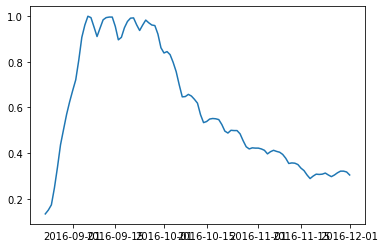

In [47]:
plt.plot(df['rolling'])


## モデル定義

In [48]:
def model1(pars, T, DT=1E-2, init = (1.0, 0., 0.0, 0.)):
    def model1_diff(Y):
        y1, y2, y3, y4 = Y
        return np.array([-pars[0]*y1, pars[0]*y1-(pars[1]+pars[2])*y2, pars[1]*y2, pars[2]*y2])
    # 時点集合
    t_set = np.linspace(0.0, T, int(T/DT) + 1)
    # SIRの各状態を格納する行列
    X = np.zeros((len(t_set),4),dtype='float')
    # 初期値から順に増分を加えることで状態変数を生成
    X[0] = init
    for tid, f in enumerate(t_set[:-1]):
        X[tid+1] = X[tid] + model1_diff(X[tid])*DT
    return X, t_set

In [49]:
def model1_standardized(pars, T, DT=1E-2, init = (0.97, 0.01, 0.01, 0.01)):
    def model1_diff(Y):
        y1, y2, y3, y4 = Y
        return np.array([-pars[0]*y1, pars[0]*y1-(pars[1]+pars[2])*y2, pars[1]*y2, pars[2]*y2])
    # 時点集合
    t_set = np.linspace(0.0, T, int(T/DT) + 1)
    # SIRの各状態を格納する行列
    X = np.zeros((len(t_set),4),dtype='float')
    # 初期値から順に増分を加えることで状態変数を生成
    X[0] = init
    for tid, f in enumerate(t_set[:-1]):
        X[tid+1] = X[tid] + model1_diff(X[tid])*DT
    X = X / np.max(X[:,1]+X[:,3])
    return X, t_set

In [50]:
def model2(pars, T, DT=1E-2, init = (1.0, 0., 0.0, 0.)):
    def model1_diff(Y):
        y1, y2, y3, y4 = Y
        return np.array([-pars[0]*y1*y2, pars[0]*y1*y2-(pars[1]+pars[2])*y2, pars[1]*y2, pars[2]*y2])
    # 時点集合
    t_set = np.linspace(0.0, T, int(T/DT) + 1)
    # SIRの各状態を格納する行列
    X = np.zeros((len(t_set),4),dtype='float')
    # 初期値から順に増分を加えることで状態変数を生成
    X[0] = init
    for tid, f in enumerate(t_set[:-1]):
        X[tid+1] = X[tid] + model1_diff(X[tid])*DT
    return X, t_set

In [51]:
def model2_standardized(pars, T, DT=1E-2, init = (0.97, 0.01, 0.01, 0.01)):
    def model1_diff(Y):
        y1, y2, y3, y4 = Y
        return np.array([-pars[0]*y1*y2, pars[0]*y1*y2-(pars[1]+pars[2])*y2, pars[1]*y2, pars[2]*y2])
    # 時点集合
    t_set = np.linspace(0.0, T, int(T/DT) + 1)
    # SIRの各状態を格納する行列
    X = np.zeros((len(t_set),4),dtype='float')
    # 初期値から順に増分を加えることで状態変数を生成
    X[0] = init
    for tid, f in enumerate(t_set[:-1]):
        X[tid+1] = X[tid] + model1_diff(X[tid])*DT
    X = X / np.max(X[:,1]+X[:,3])
    return X, t_set

## 二乗平均誤差

In [52]:
def rmse1(pars,obs):
    Y, t_set = model1_standardized(pars, len(obs))
    Y = Y[t_set >= 1]
    t_set = t_set[t_set>=1]
    y1 = Y[t_set%1==0, 0]
    y2 = Y[t_set%1==0, 1]
    y3 = Y[t_set%1==0, 2]
    y4 = Y[t_set%1==0, 3]
    ret = np.sqrt(np.average((obs - y2 - y4)**2))
    return ret

In [53]:
def rmse2(pars,obs):
    Y, t_set = model2_standardized(pars, len(obs))
    Y = Y[t_set >= 1]
    t_set = t_set[t_set>=1]
    y1 = Y[t_set%1==0, 0]
    y2 = Y[t_set%1==0, 1]
    y3 = Y[t_set%1==0, 2]
    y4 = Y[t_set%1==0, 3]
    ret = np.sqrt(np.average((obs - y2 - y4)**2))
    return ret

## フィッティング

### モデル１

In [54]:
data = df['rolling']

In [56]:
data = df['rolling']
opt1 = basinhopping(rmse1, [2.0, 0.01, 0.01], minimizer_kwargs={"args": data, "method": "L-BFGS-B"})
print(opt1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


                        fun: 0.0624803478550658
 lowest_optimization_result:       fun: 0.0624803478550658
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.50920942e-06, -1.40651379e-06, -6.59194921e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 272
      nit: 44
   status: 0
  success: True
        x: array([0.05155154, 0.03954796, 0.00213671])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 2844
                        nit: 100
                          x: array([0.05155154, 0.03954796, 0.00213671])


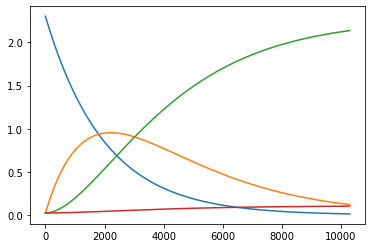

In [33]:
T = len(data)
X1, t_set = model1_standardized(opt.x, T)
fig, ax = plt.subplots()
labels = ["y1", "y2", "y3", "y4"]
for i in range(4):
    ax.plot(X1[:,i], label=labels[i])

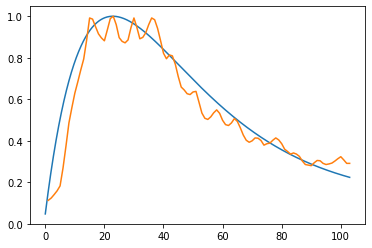

In [37]:
plt.plot(t_set ,X1[:,1]+X1[:,3])
plt.plot(pd.RangeIndex(start=0, stop=len(data.index), step=1),data)

### モデル2

In [16]:
opt2 = basinhopping(rmse2, [2.0, 0.01, 0.01], minimizer_kwargs={"args": data, "method": "L-BFGS-B"})
print(opt2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in add
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_basinhopping.py:313: RuntimeWarning: invalid value encountered in double_scalars
  w = math.exp(min(0, -float(energy_new - energy_old) * self.beta))


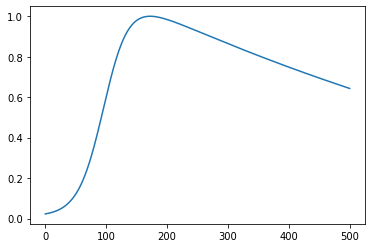

In [19]:
plt.plot(X[:,1]+X[:,3])

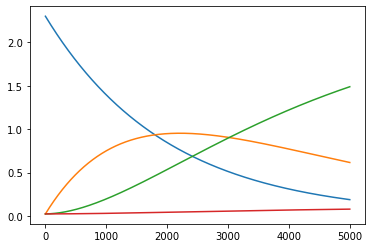

In [23]:
pars = [0.05005318, 0.03852589, 0.00144769]
#pars = [ 2.623176 , 5.11777424, 20.04359523]
T = 50
X, t_set = model1_standardized(pars, T)
fig, ax = plt.subplots()
labels = ["y1", "y2", "y3", "y4"]
for i in range(4):
    ax.plot(X[:,i], label=labels[i])

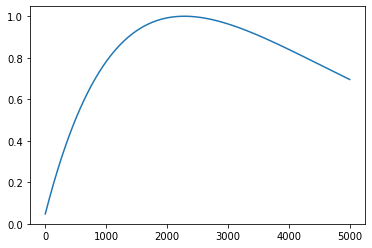

In [24]:
plt.plot(X[:,1]+X[:,3])

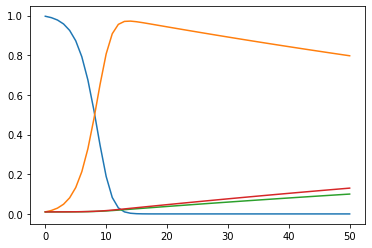

In [ ]:
pars = [7.146819,  0.02392529, 0.0319135]
#pars = [ 2.623176 , 5.11777424, 20.04359523]
T = 5
X, t_set = model2_standardized(pars, T)
fig, ax = plt.subplots()
labels = ["y1", "y2", "y3", "y4"]
for i in range(4):
    ax.plot(X[:,i], label=labels[i])

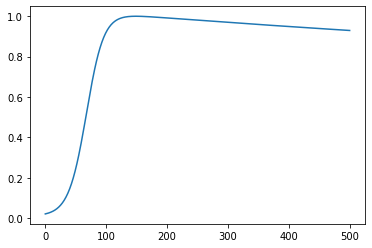

In [ ]:
plt.plot(X[:,1]+X[:,3])

In [ ]:
a = df['rolling']
opt = minimize(rmse2, [0.1, 0.8, 0.01], args=(a))

In [ ]:
opt

      fun: 0.2607786365900205
 hess_inv: array([[ 178501.48695209, -184120.30692113,  -47745.04823468],
       [-184120.30692113,  189918.05848869,   49248.22959083],
       [ -47745.04823468,   49248.22959083,   12771.86797659]])
      jac: array([-4.20957804e-07,  4.32133675e-07, -3.53157520e-06])
  message: 'Optimization terminated successfully.'
     nfev: 110
      nit: 21
     njev: 22
   status: 0
  success: True
        x: array([-3.537426  ,  4.55196085,  0.98341788])

In [ ]:
opt

                        fun: 0.26077863678444074
 lowest_optimization_result:       fun: 0.26077863678444074
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.43689571e-08, -1.05471187e-07,  7.93809463e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 1
   status: 0
  success: True
        x: array([-7.87029712,  5.56508921,  1.62884103])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1576
                        nit: 100
                          x: array([-7.87029712,  5.56508921,  1.62884103])

In [ ]:
print(opt.success)

False


In [ ]:
opt.x

array([0.11635573, 1.        , 0.00590734])

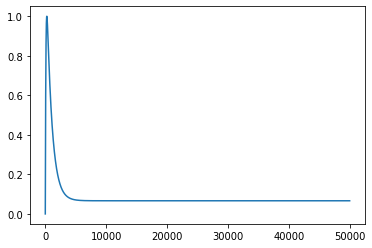

In [ ]:
res_df, t = model1_standardized(opt.x,T=500)
plt.plot(res_df[:,1]+res_df[:,3])